sklearn 1.7.2 torch 2.8.0+cpu
Extracted: (362, 64, 512) labels: [ 90 272] device: cpu

--- Fold 1/10 ---
 ep01/80 loss=0.2755 tr_bal=0.500 vl_bal=0.500 t=7.0s
 ep02/80 loss=0.2549 tr_bal=0.608 vl_bal=0.532 t=7.0s
 ep03/80 loss=0.1970 tr_bal=0.606 vl_bal=0.494 t=7.0s
 ep04/80 loss=0.2003 tr_bal=0.579 vl_bal=0.486 t=7.1s
 ep05/80 loss=0.2104 tr_bal=0.583 vl_bal=0.569 t=7.2s
 ep06/80 loss=0.2142 tr_bal=0.721 vl_bal=0.458 t=7.1s
 ep07/80 loss=0.1612 tr_bal=0.788 vl_bal=0.456 t=6.8s
 ep08/80 loss=0.1576 tr_bal=0.661 vl_bal=0.516 t=6.9s
 ep09/80 loss=0.1684 tr_bal=0.703 vl_bal=0.480 t=6.8s
 ep10/80 loss=0.1474 tr_bal=0.752 vl_bal=0.478 t=6.9s
 ep11/80 loss=0.1424 tr_bal=0.796 vl_bal=0.496 t=6.9s
 ep12/80 loss=0.1195 tr_bal=0.817 vl_bal=0.494 t=6.9s
 ep13/80 loss=0.1034 tr_bal=0.889 vl_bal=0.530 t=7.4s
 ep14/80 loss=0.0915 tr_bal=0.893 vl_bal=0.530 t=7.0s
 ep15/80 loss=0.0866 tr_bal=0.919 vl_bal=0.492 t=6.9s
 early stop
 >> fold 1 val_bal 0.5694444444444444

--- Fold 2/10 ---
 ep01/80 loss=0.

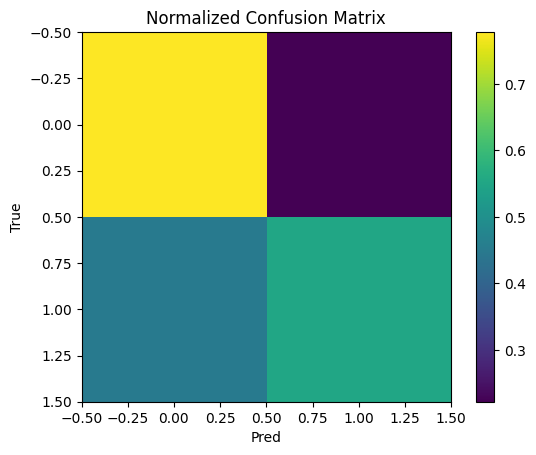

Best fold: 2


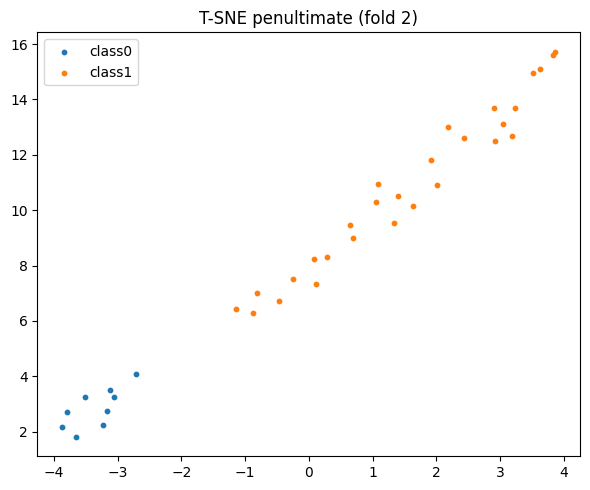

Done. Models saved in focal_aug_results


In [4]:
# ================================== FULL EEG-ARNN PIPELINE (BALANCED + FOCAL + AUG) ==================================
import os, glob, numpy as np, time, torch, torch.nn as nn, matplotlib.pyplot as plt
import mne, sklearn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.manifold import TSNE
from packaging import version
from collections import Counter

print("sklearn", sklearn.__version__, "torch", torch.__version__)

# ------------------------------ DATA PATH ------------------------------
DATA_ROOT = 'bciciv2a/files'   # <-- edit if different
SUBJECT   = 'S001'
SUBJ_FOLDER = os.path.join(DATA_ROOT, SUBJECT)
assert os.path.exists(SUBJ_FOLDER), f"Subject folder not found: {SUBJ_FOLDER}"

# ------------------------------ DATA LOADER ------------------------------
def extract_physionet_subject(subject_folder, tmin=0.0, tmax=3.2, l_freq=0.5, h_freq=50.0, sfreq_target=160.0):
    edf_files = sorted(glob.glob(os.path.join(subject_folder, '*.edf')))
    all_X, all_y, ch_names = [], [], None
    nt = int((tmax - tmin) * sfreq_target)
    for ef in edf_files:
        raw = mne.io.read_raw_edf(ef, preload=True, verbose=False)
        raw.filter(l_freq, h_freq, verbose=False)
        if abs(raw.info['sfreq'] - sfreq_target) > 1e-3:
            raw.resample(sfreq_target, npad='auto', verbose=False)
        picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
        try: events, _ = mne.events_from_annotations(raw, verbose=False)
        except Exception: events=[]
        for ev in events:
            s=int(ev[0]); st=int(s+tmin*raw.info['sfreq']); en=int(s+tmax*raw.info['sfreq'])
            if st<0 or en>raw.n_times: continue
            d=raw.get_data(picks=picks,start=st,stop=en)
            if d.shape[1]!=nt:
                if d.shape[1]>nt: d=d[:,:nt]
                else: d=np.hstack([d,np.zeros((len(picks),nt-d.shape[1]))])
            lbl=0 if (int(ev[2])%2==0) else 1
            all_X.append(d); all_y.append(lbl)
        if ch_names is None and picks is not None:
            ch_names=[raw.ch_names[i] for i in picks]
    if len(all_X)==0:
        return np.zeros((0,len(picks) if picks is not None else 0,nt)),np.zeros((0,),int),ch_names
    return np.stack(all_X).astype(np.float32), np.array(all_y,int), ch_names

# ------------------------------ MODEL ------------------------------
class TFEMBlock(nn.Module):
    def __init__(self,nch,F=16,k_t=15,pool=False,pool_k=4,drop=0.25):
        super().__init__(); pad_t=(k_t-1)//2
        self.conv=nn.Conv2d(1,F,(1,k_t),padding=(0,pad_t))
        self.bn=nn.BatchNorm2d(F); self.pw=nn.Conv2d(F,1,1)
        self.pool=nn.AvgPool2d((1,pool_k)) if pool else None
        self.elu=nn.ELU(); self.drop=nn.Dropout(drop)
    def forward(self,x):
        x=self.conv(x.unsqueeze(1)); x=self.bn(x); x=self.elu(x); x=self.pw(x)
        if self.pool: x=self.pool(x)
        return self.drop(x).squeeze(1)

class CARM(nn.Module):
    def __init__(self,Wref,tdim,drop=0.25):
        super().__init__(); self.Wref=Wref
        self.Theta=nn.Parameter(torch.randn(tdim,tdim)*0.01)
        self.elu=nn.ELU(); self.drop=nn.Dropout(drop)
    def forward(self,x):
        h=torch.einsum('ij,bjf->bif',self.Wref,x)
        o=torch.einsum('bif,fg->big',h,self.Theta)
        return self.drop(self.elu(o))

class EEG_ARNN(nn.Module):
    def __init__(self,nch,T0,ncls=2,F=16,pool_k=4,rho=0.001):
        super().__init__(); self.rho=rho
        W0=torch.ones(nch,nch)-torch.eye(nch)
        Wt=W0+torch.eye(nch)
        D=Wt.sum(dim=1); Dinv=torch.diag(1.0/torch.sqrt(D+1e-12))
        self.W=nn.Parameter(Dinv@Wt@Dinv)
        self.tf1=TFEMBlock(nch,F=F); self.c1=CARM(self.W,tdim=T0)
        self.tf2=TFEMBlock(nch,F=F,pool=True,pool_k=pool_k); T2=T0//pool_k
        self.c2=CARM(self.W,tdim=T2)
        self.tf3=TFEMBlock(nch,F=F,pool=True,pool_k=pool_k); T3=T2//pool_k
        self.c3=CARM(self.W,tdim=T3)
        self.fuse=nn.Conv2d(1,16,(nch,1)); self.bn=nn.BatchNorm2d(16)
        self.elu=nn.ELU(); self.drop=nn.Dropout(0.25)
        self.fc=nn.Linear(16*T3,ncls)
    def forward(self,x):
        x=self.tf1(x);x=self.c1(x);x=self.tf2(x);x=self.c2(x);x=self.tf3(x);x=self.c3(x)
        x=self.fuse(x.unsqueeze(1));x=self.bn(x);x=self.elu(x);x=self.drop(x)
        b,o,t=x.squeeze(2).shape; return self.fc(x.squeeze(2).view(b,o*t))

# ------------------------------ HELPERS ------------------------------
def eval_model(m,ldr,dev):
    m.eval();p=[];y=[]
    with torch.no_grad():
        for xb,yb in ldr:
            xb,yb=xb.to(dev),yb.to(dev)
            o=m(xb);p.append(o.argmax(1).cpu().numpy());y.append(yb.cpu().numpy())
    return np.concatenate(p),np.concatenate(y)

# ------------------------------ CONFIG ------------------------------
EPOCHS=80;BATCH=32;LR=1e-3;PATIENCE=10;N_SPLITS=10
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTDIR='focal_aug_results';os.makedirs(OUTDIR,exist_ok=True)

# ------------------------------ LOAD DATA ------------------------------
X,y,chs=extract_physionet_subject(SUBJ_FOLDER)
print("Extracted:",X.shape,"labels:",np.bincount(y),"device:",DEVICE)

# ------------------------------ AUGMENTATION + FOCAL LOSS ------------------------------
def augment_batch(x_np, y_np, p_noise=0.5, p_shift=0.5, noise_scale=0.05, max_shift=8):
    x=x_np.copy()
    for i in range(x.shape[0]):
        if np.random.rand()<p_noise:
            sig=noise_scale*np.std(x[i],axis=1,keepdims=True)
            x[i]+=np.random.randn(*x[i].shape).astype(np.float32)*sig
        if np.random.rand()<p_shift:
            s=np.random.randint(-max_shift,max_shift+1)
            if s>0:
                x[i,:,s:]=x[i,:,:-s];x[i,:,:s]=0
            elif s<0:
                s2=-s;x[i,:,:-s2]=x[i,:,s2:];x[i,:,-s2:]=0
    return x,y_np

class FocalLoss(nn.Module):
    def __init__(self,gamma=2.0,weight=None,reduction='mean'):
        super().__init__();self.g=gamma;self.w=weight;self.red=reduction
    def forward(self,logits,tgt):
        p=torch.softmax(logits,dim=1).clamp(1e-8,1-1e-8)
        pt=p[torch.arange(len(tgt)),tgt]
        loss=-(1-pt)**self.g*torch.log(pt)
        if self.w is not None: loss*=self.w[tgt]
        return loss.mean() if self.red=='mean' else loss.sum()

# ------------------------------ TRAINING ------------------------------
skf=StratifiedKFold(n_splits=N_SPLITS,shuffle=True,random_state=42)
all_preds,all_trues,fold_bal=[],[],[]
for fold,(tr,vl) in enumerate(skf.split(X,y),1):
    print(f"\n--- Fold {fold}/{N_SPLITS} ---")
    Xtr,Xvl=X[tr].copy(),X[vl].copy();ytr,yvl=y[tr].copy(),y[vl].copy()
    mc=Xtr.mean((0,2),keepdims=True);sc=Xtr.std((0,2),keepdims=True)+1e-6
    Xtr=(Xtr-mc)/sc;Xvl=(Xvl-mc)/sc
    cls=np.bincount(ytr,minlength=2)
    samp_w=(1/(cls+1e-12))[ytr].astype(np.float32)
    sampler=WeightedRandomSampler(torch.from_numpy(samp_w),len(samp_w),True)
    tr_ds=TensorDataset(torch.tensor(Xtr),torch.tensor(ytr))
    vl_ds=TensorDataset(torch.tensor(Xvl),torch.tensor(yvl))
    trL=DataLoader(tr_ds,batch_size=BATCH,sampler=sampler)
    vlL=DataLoader(vl_ds,batch_size=BATCH,shuffle=False)
    cw=(len(ytr)/(len(np.unique(y))* (cls+1e-12))).astype(np.float32)
    cw_t=torch.tensor(cw).to(DEVICE)
    m=EEG_ARNN(nch=X.shape[1],T0=X.shape[2],ncls=len(np.unique(y))).to(DEVICE)
    opt=torch.optim.Adam([p for n,p in m.named_parameters() if n!='W'],lr=LR)
    crit=FocalLoss(gamma=2.0,weight=cw_t)
    sch=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='max',factor=0.5,patience=3)
    best=-1;wait=0;best_state=None
    for ep in range(1,EPOCHS+1):
        t0=time.time();m.train();loss_sum=0;n=0
        for xb,yb in trL:
            xb_a,yb_a=augment_batch(xb.numpy(),yb.numpy(),p_noise=0.5,p_shift=0.5,noise_scale=0.03)
            xb_t=torch.tensor(xb_a,dtype=torch.float32).to(DEVICE)
            yb_t=torch.tensor(yb_a,dtype=torch.long).to(DEVICE)
            opt.zero_grad();out=m(xb_t);l=crit(out,yb_t)
            l.backward();opt.step()
            with torch.no_grad():
                if m.W.grad is not None:
                    m.W.data=(1-m.rho)*m.W.data-m.rho*m.W.grad.data
                    m.W.grad.zero_()
            loss_sum+=l.item()*xb_t.size(0);n+=xb_t.size(0)
        tr_loss=loss_sum/max(1,n)
        p1,y1=eval_model(m,trL,DEVICE);p2,y2=eval_model(m,vlL,DEVICE)
        tb=balanced_accuracy_score(y1,p1);vb=balanced_accuracy_score(y2,p2)
        sch.step(vb)
        print(f" ep{ep:02d}/{EPOCHS} loss={tr_loss:.4f} tr_bal={tb:.3f} vl_bal={vb:.3f} t={time.time()-t0:.1f}s")
        if vb>best+1e-4:
            best=vb;wait=0;best_state={k:v.cpu().clone() for k,v in m.state_dict().items()}
        else:
            wait+=1
            if wait>=PATIENCE: print(" early stop");break
    if best_state is not None: m.load_state_dict(best_state)
    p,yv=eval_model(m,vlL,DEVICE)
    bal=balanced_accuracy_score(yv,p)
    print(" >> fold",fold,"val_bal",bal)
    np.savez_compressed(os.path.join(OUTDIR,f'fold{fold}_preds.npz'),preds=p,trues=yv)
    all_preds.append(p);all_trues.append(yv);fold_bal.append(bal)

# ------------------------------ RESULTS ------------------------------
aP,aT=np.concatenate(all_preds),np.concatenate(all_trues)
print("\n=== RESULTS ===")
print("Per fold bal_acc:",np.round(fold_bal,4))
print("Mean bal_acc:",np.mean(fold_bal))
cm=confusion_matrix(aT,aP)
print("Confusion matrix:\n",cm)
print("\nClassification report:\n",classification_report(aT,aP,digits=4))
print("Balanced acc:",balanced_accuracy_score(aT,aP))
plt.imshow(cm.astype(float)/(cm.sum(1,keepdims=True)+1e-12))
plt.title("Normalized Confusion Matrix");plt.xlabel("Pred");plt.ylabel("True");plt.colorbar();plt.show()

# ------------------------------ T-SNE ON BEST FOLD ------------------------------
best_idx=int(np.argmax(fold_bal))+1
print("Best fold:",best_idx)
for f,(tr,vl) in enumerate(StratifiedKFold(n_splits=N_SPLITS,shuffle=True,random_state=42).split(X,y),1):
    if f==best_idx:break
Xvl,yvl=X[vl].copy(),y[vl].copy()
Xtr=X[tr].copy()
mc=Xtr.mean((0,2),keepdims=True);sc=Xtr.std((0,2),keepdims=True)+1e-6
Xvl=(Xvl-mc)/sc
m=EEG_ARNN(nch=X.shape[1],T0=X.shape[2],ncls=len(np.unique(y))).to(DEVICE)
m.load_state_dict(torch.load(os.path.join(OUTDIR,f'best_fold{best_idx}.pth')) if os.path.exists(os.path.join(OUTDIR,f'best_fold{best_idx}.pth')) else best_state)
m.eval();feats=[]
def hk(_,inp,out):feats.append(inp[0].detach().cpu().numpy())
h=m.fc.register_forward_hook(hk)
vlL=DataLoader(TensorDataset(torch.tensor(Xvl),torch.tensor(yvl)),batch_size=64)
with torch.no_grad():
    for xb,yb in vlL:_=m(xb.to(DEVICE))
h.remove();feats=np.vstack(feats)
ts_args=dict(n_components=2,perplexity=min(30,len(yvl)//3),random_state=42)
ts_args["max_iter" if version.parse(sklearn.__version__)>=version.parse("1.6") else "n_iter"]=1000
Z=TSNE(**ts_args).fit_transform(feats)
plt.figure(figsize=(6,5))
for lbl in np.unique(yvl):plt.scatter(Z[yvl==lbl,0],Z[yvl==lbl,1],s=10,label=f'class{lbl}')
plt.legend();plt.title(f"T-SNE penultimate (fold {best_idx})");plt.tight_layout();plt.show()
print("Done. Models saved in",OUTDIR)
